# Large-Scale Analysis of the Co-Commit Patterns of the Active Developers in GitHub’s Top Repositories (MSR'18)
## Part 2: Graphs Analysis
**Eldan Cohen, Mariano P. Consens**

This notebook produces the analysis described in the paper
## 1. Framework
In this section we provide the code that will be used to perform the analysis

In [1]:
# required imports

import pandas as pd
import numpy as np
from datetime import datetime
import networkit as nk
import os.path
import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def buildGraph(df):
    """
    buildGraph takes a dataframe with two columns (login1, login2) that represents the edges in the developer graph
    and constructs a NetworKit graph (self-edges are not considered in the graph, but are used to add isolated nodes).
    """
    
    g = nk.Graph() # initialize empty graph
    nodeIDs = {} # nodeIDs will keep the node id assigned to each developer
    
    # For each edge, check if both nodes are already in the graph (and if not, add them).
    # Then, add the edge between them.
    for login1, login2 in df.itertuples(index = False):
        if login1 not in nodeIDs:
            nodeIDs[login1] = g.addNode()
        if login2 not in nodeIDs:
            nodeIDs[login2] = g.addNode()
        if login1 == login2 :
            continue
        if not g.hasEdge(nodeIDs[login1], nodeIDs[login2]):
            g.addEdge(nodeIDs[login1], nodeIDs[login2])
    
    return (g, nodeIDs)

GraphWrapper is a class that wraps a NetworKit graph and computes the different metrics for the graph:

In [3]:
def computeFirst(originalFunction):
    """
    A help function that implements computeFirst decorator.
    ComputeFirst will enforce that the analysis functions in GraphWrapper
        will not be called before the needed structures are computed.
    """
    def checkComputedFunction(*args,**kwargs):
        graphObj = args[0] # args[0] is self
        assert (graphObj.isComputed()), "Must call compute() before using method %s." % (originalFunction.__name__,)
        return originalFunction(*args, **kwargs)
    return checkComputedFunction

In [28]:
class GraphWrapper:
    """
    A class that wraps a NetworKit graph and computes the different analysis metrics.
    """
    def __init__(self, nkGraph):
        self._graph = nkGraph
        self._isComputed = False
    
    def compute(self):
        """
        This function performs the requied computations on the graphs. The results will be provided by the other functions.
        """
        
        # Calculate the component strucutre of the graph
        self._components = nk.components.ConnectedComponents(self._graph)
        self._components.run()
        self._compPartition = self._components.getPartition()
        
        # Perform community detection using the Parallel Louvain Method
        self._plm = nk.community.PLM(self._graph, refine=True)
        self._plm.run()
        
        # Construct a graph for the giant component
        subgraphGiant = self._graph.subgraphFromNodes(self._compPartition.getMembers(np.argmax(self._compPartition.subsetSizes())))
        
        self._giantGraph = nk.Graph()
        indexConvert = dict()
        for n in subgraphGiant.nodes():
            indexConvert[n] = self._giantGraph.addNode()

        for (n1,n2) in subgraphGiant.edges():
            newN1 = indexConvert[n1]
            newN2 = indexConvert[n2]
            self._giantGraph.addEdge(newN1, newN2)
        
        # Calculate betweenness for the giant graph
        self._giantBetw = nk.centrality.Betweenness(self._giantGraph)
        self._giantBetw.run()
        
        # Mark this GraphWrapper as computed
        self._isComputed = True
    
    def isComputed(self):
        return self._isComputed
        
    @computeFirst
    def numNodes(self):
        """
        Returns the number of nodes in the graphs
        """
        return len(self._graph.nodes())
    
    @computeFirst
    def giantPercent(self):
        """
        Returns the relative size of the giant component in the graph as percentage.
        """
        giant = 100*float(max(self._compPartition.subsetSizes()))/self._graph.numberOfNodes()
        return giant
    
    @computeFirst
    def allComponentsPercent(self):
        """
        Returns the relative size of all components in the graph as percentage.
        """
        return [100*float(compSize)/self._graph.numberOfNodes() for compSize in sorted(self._compPartition.subsetSizes(), reverse = True)]

    @computeFirst
    def giantBetweennessCentralization(self):
        """
        Returns the betweenness centralization of the giant component in the graph.
        [adopted from http://igraph.wikidot.com/python-recipes#toc2]
        """
        numNodes = len(self._giantGraph.nodes())
        assert numNodes >= 3, "At least 3 nodes"
        denom = (numNodes-1)*(numNodes-2)

        normalizedScores = [score/denom for score in self._giantBetw.scores()]
        maxScore = max(normalizedScores)
        return sum(maxScore-score for score in normalizedScores)/(numNodes-1)

    @computeFirst
    def normMeanDegree(self):
        """
        Returns the normalized mean degree.
        """
        return 100*float(np.mean(list(map(lambda n: self._graph.degree(n), self._graph.nodes()))))/len(self._graph.nodes())
    
    @computeFirst
    def normMedianDegree(self):
        """
        Returns the normalized median degree.
        """
        return 100*float(np.median(list(map(lambda n: self._graph.degree(n), self._graph.nodes()))))/len(self._graph.nodes())
    
    @computeFirst
    def modularity(self):
        """
        Returns the modularity of the louvain community detection.
        """
        return nk.community.Modularity().getQuality(self._plm.getPartition(), self._graph)
    
    @computeFirst
    def numCommunities(self):
        """
        Returns the number of communities detected by the louvain community detection.
        """
        return self._plm.getPartition().numberOfSubsets()
    
    @computeFirst
    def avgCommSize(self):
        """
        Returns the average size of community detected by the louvain community detection.
        """
        return np.mean(self._plm.getPartition().subsetSizes())
    
    @computeFirst
    def degreeSequence(self):
        """
        Returns the normalized degree of all nodes in graph.
        """
        return np.array(list(map(lambda n: self._graph.degree(n), self._graph.nodes())))/len(self._graph.nodes())


In [5]:
DF_COLUMNS = ["language", "networkType", "numContributors", "% GC", "NMeanDeg", "NMedDeg", "BetwCentr", "numCommunities", "avgCommunitySize", "modularity", "nextThreeComponents", "degrees"]
DF_FORMAT = {'% GC': '{:.1f}', 'NMeanDeg':'{:.1f}', 'NMedDeg':'{:.1f}', 'BetwCentr':'{:.2f}', 'avgCommunitySize':'{:.2f}', 'modularity':'{:.2f}', 'degrees': '[...]'}

def buildSummaryDataFrame(fileList):
    """
    The function takes a folder of CSV files (each describes a full or core network of a language in a time period)
    and creates a dataframe with the computed metrics each of the networks.
    """
    tupleList = []
    for file in fileList:
        # Read dataframe
        df = pd.read_csv(file, names=["login1", "login2"])
        gr = GraphWrapper(buildGraph(df)[0])
        gr.compute()
        
        # Extract language name from filename
        language, networkType = os.path.basename(file).split(".")[0].split("_")

        # Calculate each langauge's metrics
        numNodes = gr.numNodes()
        giantPercent = gr.giantPercent()
        normMeanDegree = gr.normMeanDegree()
        normMedianDegree = gr.normMedianDegree()
        betwCentr = gr.giantBetweennessCentralization()
        modularity = gr.modularity()
        numCommunities = gr.numCommunities()
        avgCommunitySize = gr.avgCommSize()
        sizeComponents = ["%.1f" % (compSize,) for compSize in gr.allComponentsPercent()[1:4]]
        degreeSequence = gr.degreeSequence()
        
        # Add a record to the dataframe
        tupleList.append((language,
                          networkType,
                          numNodes,
                          giantPercent,
                          normMeanDegree,
                          normMedianDegree,
                          betwCentr,
                          numCommunities,
                          avgCommunitySize,
                          modularity,
                          sizeComponents,
                          degreeSequence))
        # Report progress
        print(language, end="; ")
        
    print() # New line
    return pd.DataFrame(tupleList, columns = DF_COLUMNS)

def formatSummaryDF(df):
    return df.style.format(DF_FORMAT)

In [6]:
LANGUAGES = ['Python', 'Javascript', 'Clojure', 'Scala', 'Java', 'Scheme', 'Ruby', 'C#', 
             'C++', 'C', 'Go', 'Haskell', 'Julia', 'OCaml', 'PHP', 'R', 'Rust']

def buildDegSeqDF(coreDF, fullDF):
    """
    A help function that creates a DF of the degree sequences of all languages.
    """
    degreeTuples = []
    for language in LANGUAGES:
        langNum = [num for num, name in enumerate(coreDF["language"]) if name.lower() == language.lower()][0]
        coreDF["language"]

        coreDegreeSequence = coreDF["degrees"][langNum]
        cy,cx = np.histogram(coreDegreeSequence, bins=50)
        cyN = cy/sum(cy)
        cyNC = np.cumsum(cyN)

        for x,y in zip(cx[1:], cyNC):
            degreeTuples.append((language, "Core", x, y))

        fullDegreeSequence = fullDF["degrees"][langNum]
        fy,fx = np.histogram(fullDegreeSequence, bins=50)
        fyN = fy/sum(fy)
        fyNC = np.cumsum(fyN)
        for x,y in zip(fx[1:], fyNC):
            degreeTuples.append((language, "Full", x, y))
    
    return pd.DataFrame(degreeTuples, columns = ["language", "network", "ndeg", "CDF"])

def degDistPlot(coreDF, fullDF, plotsInRow = 4):
    """
    This function gets two DF created by buildDegSeqDF: one for the core and one for the full.
    It plots the degree distribution for all languages, comparing the core and full of each language.
    """
    degSeqDF = buildDegSeqDF(coreDF, fullDF)
    degPlot = sns.FacetGrid(degSeqDF, col="language", col_wrap=plotsInRow, hue="network").map(plt.plot, "ndeg", "CDF", lw=3, marker='s', markersize = 7)
    degPlot.set(xscale="log", xlim=(0.0001,1.1), ylim=(0,1.1))
    degPlot.fig.subplots_adjust(wspace=.1, hspace=.1)
    degPlot.add_legend()
    return

## 2. Results for time period $t_1$

### 2.1. Results for core network $\pi_1^*$

Create a list of all **core** network files in time period 1:

In [7]:
t1CoreFiles = sorted(glob.glob("gh_graphs/g1/*_core.csv"))

In [8]:
t1CoreFiles

['gh_graphs/g1/C#_core.csv',
 'gh_graphs/g1/C++_core.csv',
 'gh_graphs/g1/C_core.csv',
 'gh_graphs/g1/Clojure_core.csv',
 'gh_graphs/g1/Go_core.csv',
 'gh_graphs/g1/Haskell_core.csv',
 'gh_graphs/g1/Java_core.csv',
 'gh_graphs/g1/Javascript_core.csv',
 'gh_graphs/g1/Julia_core.csv',
 'gh_graphs/g1/Ocaml_core.csv',
 'gh_graphs/g1/Php_core.csv',
 'gh_graphs/g1/Python_core.csv',
 'gh_graphs/g1/R_core.csv',
 'gh_graphs/g1/Ruby_core.csv',
 'gh_graphs/g1/Rust_core.csv',
 'gh_graphs/g1/Scala_core.csv',
 'gh_graphs/g1/Scheme_core.csv']

Compute the metrics for the core networks and print the resutls:

In [9]:
t1CoreDF = buildSummaryDataFrame(t1CoreFiles)

C#; C++; C; Clojure; Go; Haskell; Java; Javascript; Julia; Ocaml; Php; Python; R; Ruby; Rust; Scala; Scheme; 


In [10]:
formatSummaryDF(t1CoreDF)

,language,networkType,numContributors,% GC,NMeanDeg,NMedDeg,BetwCentr,numCommunities,avgCommunitySize,modularity,nextThreeComponents,degrees
0,C#,core,1510,22.7,0.6,0.2,0.31,447,3.38,0.84,"['3.3', '2.3', '2.3']",[...]
1,C++,core,2696,5.5,0.4,0.2,0.33,627,4.30,0.95,"['4.5', '2.6', '1.7']",[...]
2,C,core,2195,22.9,2.5,0.3,0.15,515,4.26,0.22,"['1.7', '1.4', '1.3']",[...]
3,Clojure,core,403,12.2,0.5,0.2,0.60,180,2.24,0.94,"['5.7', '3.5', '3.0']",[...]
4,Go,core,1688,46.9,0.7,0.3,0.34,385,4.38,0.83,"['1.6', '1.3', '1.2']",[...]
5,Haskell,core,519,38.5,0.7,0.4,0.33,194,2.68,0.75,"['2.5', '1.3', '1.2']",[...]
6,Java,core,1834,5.1,0.6,0.3,0.08,459,4.00,0.89,"['5.1', '3.2', '2.7']",[...]
7,Javascript,core,2527,38.1,0.4,0.2,0.62,528,4.79,0.88,"['0.9', '0.8', '0.7']",[...]
8,Julia,core,341,62.5,5.2,0.6,0.13,109,3.13,0.20,"['0.9', '0.9', '0.6']",[...]
9,Ocaml,core,274,43.1,2.8,0.7,0.24,93,2.95,0.57,"['5.5', '2.9', '2.9']",[...]


### 2.2 Results for full network $\pi_1$

Create a list of all **full** network files in time period 1:

In [11]:
t1FullFiles = sorted(glob.glob("gh_graphs/g1/*_full.csv"))

Compute the metrics for the full networks and print the resutls:

In [12]:
t1FullDF = buildSummaryDataFrame(t1FullFiles)

C#; C++; C; Clojure; Go; Haskell; Java; Javascript; Julia; Ocaml; Php; Python; R; Ruby; Rust; Scala; Scheme; 


In [13]:
formatSummaryDF(t1FullDF)

,language,networkType,numContributors,% GC,NMeanDeg,NMedDeg,BetwCentr,numCommunities,avgCommunitySize,modularity,nextThreeComponents,degrees
0,C#,full,5269,83.5,0.9,0.4,0.14,192,27.44,0.77,"['0.6', '0.6', '0.4']",[...]
1,C++,full,11246,88.2,0.7,0.3,0.20,258,43.59,0.89,"['0.6', '0.5', '0.3']",[...]
2,C,full,9700,87.4,4.1,0.5,0.05,208,46.63,0.20,"['0.7', '0.6', '0.4']",[...]
3,Clojure,full,1241,89.6,1.1,0.8,0.17,55,22.56,0.79,"['0.7', '0.6', '0.6']",[...]
4,Go,full,7035,95.5,1.9,0.6,0.07,93,75.65,0.70,"['0.2', '0.2', '0.2']",[...]
5,Haskell,full,1439,89.6,2.1,0.8,0.10,52,27.67,0.58,"['1.0', '0.9', '0.8']",[...]
6,Java,full,7570,89.2,1.4,0.5,0.10,149,50.81,0.69,"['0.5', '0.4', '0.4']",[...]
7,Javascript,full,14250,96.2,0.8,0.4,0.30,115,123.91,0.76,"['0.2', '0.1', '0.1']",[...]
8,Julia,full,746,94.8,21.8,24.5,0.07,23,32.43,0.18,"['0.4', '0.4', '0.4']",[...]
9,Ocaml,full,740,85.1,10.1,3.1,0.08,49,15.10,0.45,"['2.4', '1.1', '0.8']",[...]


### 2.3. Degree distribution in $t_1$: core vs. full

Comparison of the degree distribution in the core vs. the full for each of the languages in time period t1:

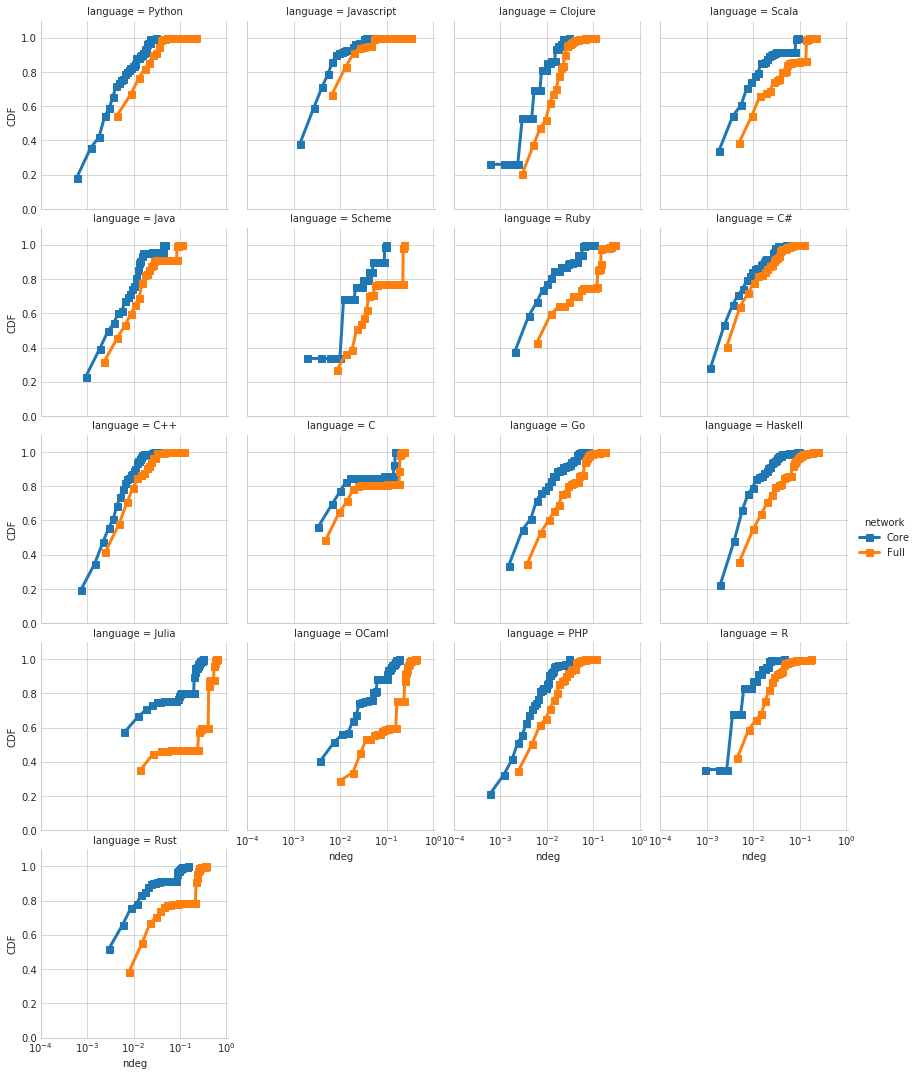

In [14]:
degDistPlot(t1CoreDF, t1FullDF)

## 3. Evolution of co-commit patterns

First, we collect the metrics for all networks at all time periods:

In [15]:
periodsCoreGraphs = dict()
periodsFullGraphs = dict()

for period in range(1,11):
    print ("- Processing core networks for period t%d:" % (period,))
    periodCoreFiles = sorted(glob.glob("gh_graphs/g%d/*_core.csv" % (period,)))
    periodsCoreGraphs[period] = buildSummaryDataFrame(periodCoreFiles)
    
    print ("- Processing full networks for period t%d:" % (period,))
    periodFullFiles = sorted(glob.glob("gh_graphs/g%d/*_full.csv" % (period,)))
    periodsFullGraphs[period] = buildSummaryDataFrame(periodFullFiles)

- Processing core networks for period t1:
C#; C++; C; Clojure; Go; Haskell; Java; Javascript; Julia; Ocaml; Php; Python; R; Ruby; Rust; Scala; Scheme; 
- Processing full networks for period t1:
C#; C++; C; Clojure; Go; Haskell; Java; Javascript; Julia; Ocaml; Php; Python; R; Ruby; Rust; Scala; Scheme; 
- Processing core networks for period t2:
C#; C++; C; Clojure; Go; Haskell; Java; Javascript; Julia; Ocaml; Php; Python; R; Ruby; Rust; Scala; Scheme; 
- Processing full networks for period t2:
C#; C++; C; Clojure; Go; Haskell; Java; Javascript; Julia; Ocaml; Php; Python; R; Ruby; Rust; Scala; Scheme; 
- Processing core networks for period t3:
C#; C++; C; Clojure; Go; Haskell; Java; Javascript; Julia; Ocaml; Php; Python; R; Ruby; Rust; Scala; Scheme; 
- Processing full networks for period t3:
C#; C++; C; Clojure; Go; Haskell; Java; Javascript; Julia; Ocaml; Php; Python; R; Ruby; Rust; Scala; Scheme; 
- Processing core networks for period t4:
C#; C++; C; Clojure; Go; Haskell; Java; Javasc

Then, we build a unified dataframe with all the information to allow plotting:

In [16]:
EVOLUTION_FIELDS = ["% GC", "NMeanDeg", "BetwCentr", "numCommunities"]

allPeriodsDFs = []
for period in range(1,11):
    allPeriodsDFs.append(periodsCoreGraphs[period][["language", "networkType", *EVOLUTION_FIELDS]].assign(period=period))
    allPeriodsDFs.append(periodsFullGraphs[period][["language", "networkType", *EVOLUTION_FIELDS]].assign(period=period))
evolutionDF = pd.concat(allPeriodsDFs).reset_index()
evolutionDF["language"] = pd.Categorical(evolutionDF["language"], LANGUAGES)

### 3.1. Evolution of Giant Component

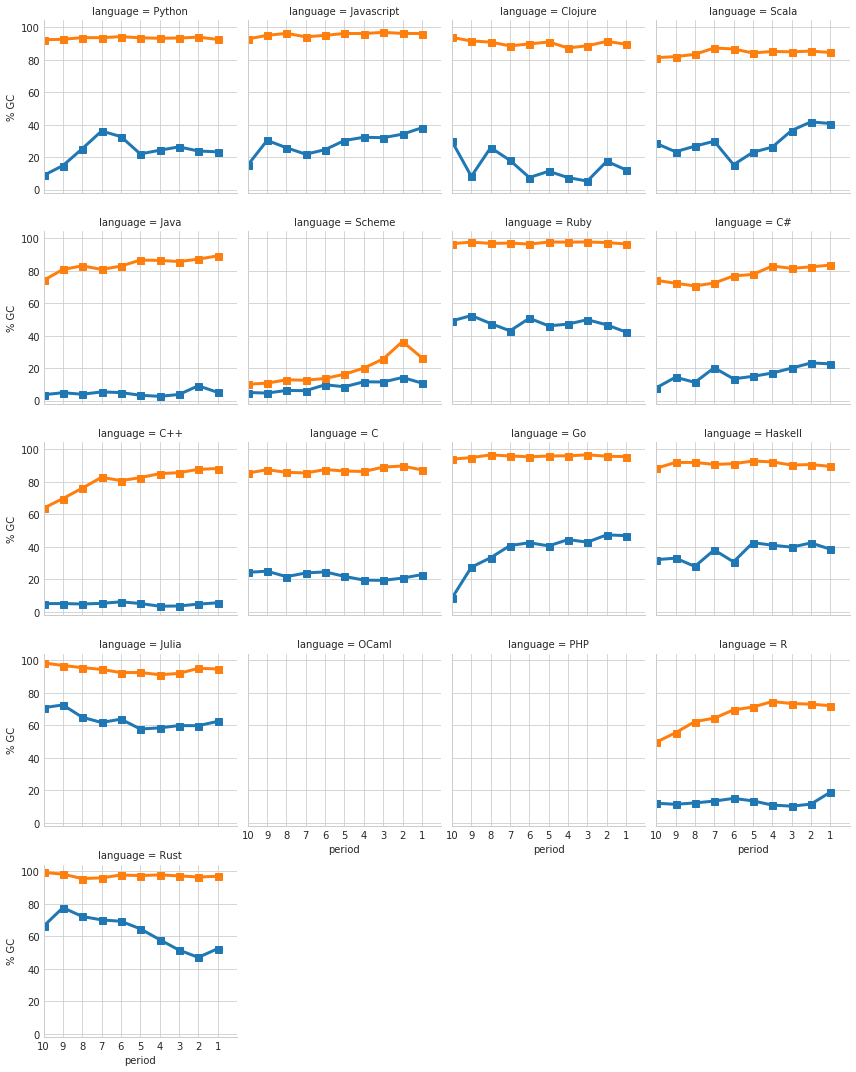

In [17]:
sns.FacetGrid(evolutionDF, col="language", col_wrap=4, hue="networkType").\
    map(plt.plot, "period", "% GC", lw=3, marker='s', markersize = 7).\
    set(xlim=(10,0), xticks=np.arange(1,11))

### 3.2. Evolution of Mean Normalized Degree (ndeg)

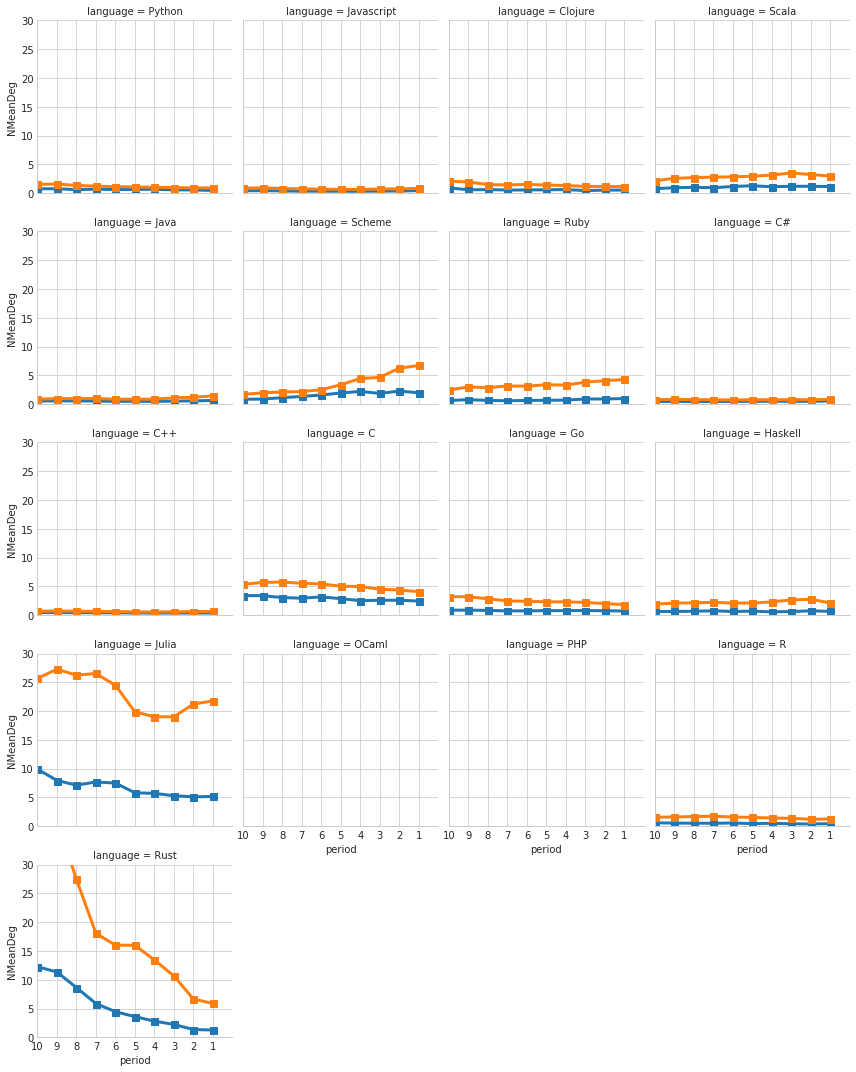

In [18]:
sns.FacetGrid(evolutionDF, col="language", col_wrap=4, hue="networkType").\
    map(plt.plot, "period", "NMeanDeg", lw=3, marker='s', markersize = 7).\
    set(xlim=(10,0), xticks=np.arange(1,11), ylim=(0, 30))

### 3.3. Evolution of Betweenness Centralization

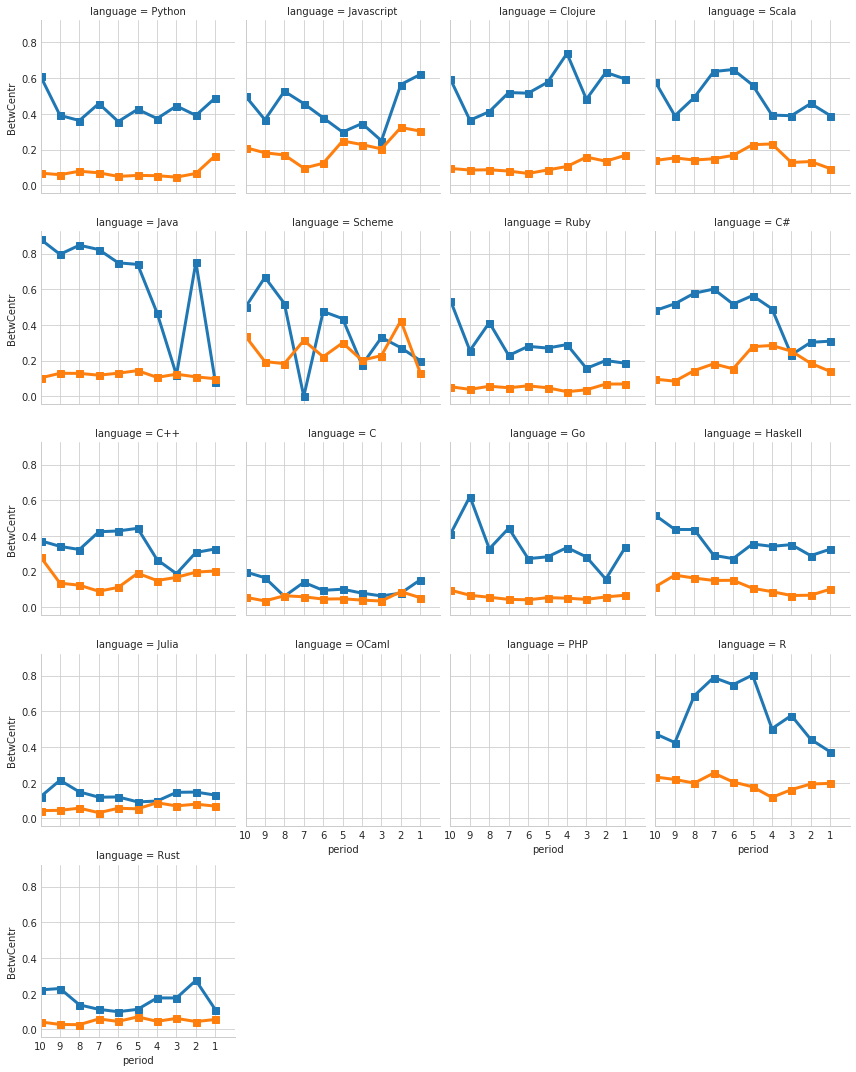

In [19]:
sns.FacetGrid(evolutionDF, col="language", col_wrap=4, hue="networkType").\
    map(plt.plot, "period", "BetwCentr", lw=3, marker='s', markersize = 7).\
    set(xlim=(10,0), xticks=np.arange(1,11))

### 3.4. Evolution of Number of Communities

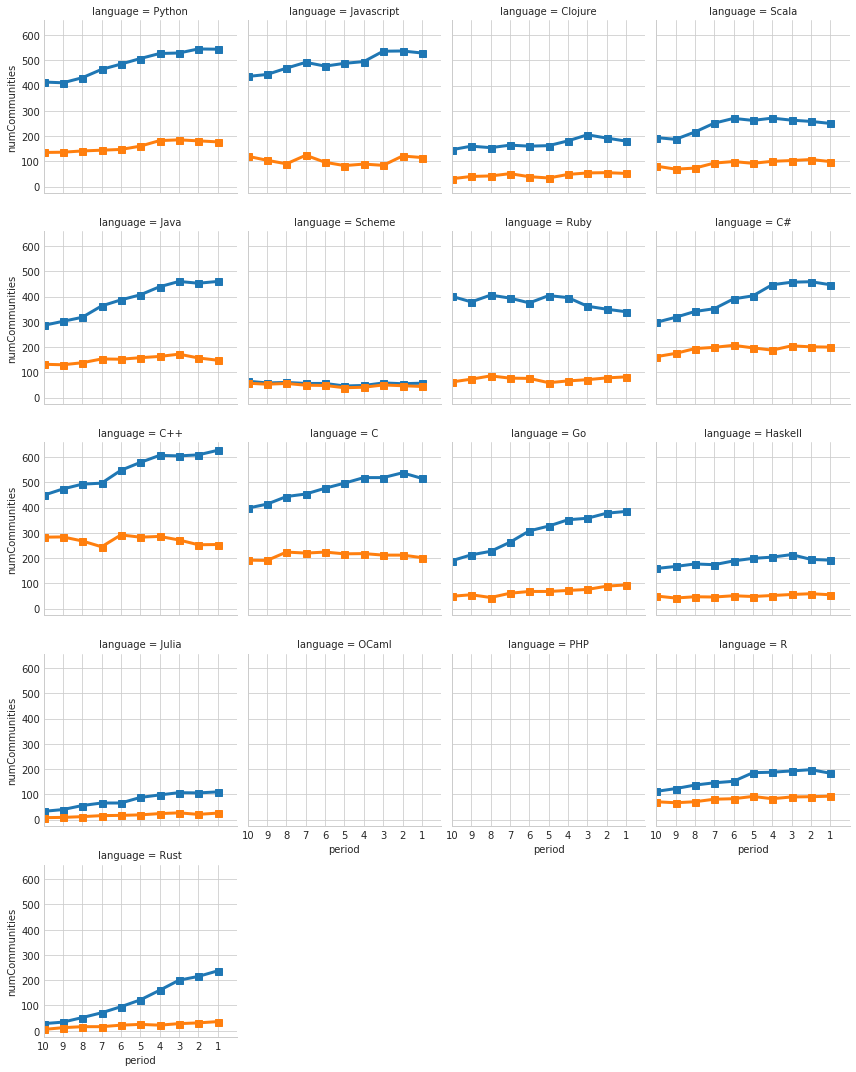

In [20]:
sns.FacetGrid(evolutionDF, col="language", col_wrap=4, hue="networkType").\
    map(plt.plot, "period", "numCommunities", lw=3, marker='s', markersize = 7).\
    set(xlim=(10,0), xticks=np.arange(1,11))

## 4. Results for the commulative network (time period $t_c$)

In this section we present the results for the core and full cumulative networks (time period $t_c$)

### 4.1. Results for core network $\pi_c^*$

In [21]:
tcCoreFiles = sorted(glob.glob("gh_graphs/gc/*_core.csv"))

In [22]:
tcCoreDF = buildSummaryDataFrame(tcCoreFiles)

C#; C++; C; Clojure; Go; Haskell; Java; Javascript; Julia; Ocaml; Php; Python; R; Ruby; Rust; Scala; Scheme; 


In [23]:
formatSummaryDF(tcCoreDF)

,language,networkType,numContributors,% GC,NMeanDeg,NMedDeg,BetwCentr,numCommunities,avgCommunitySize,modularity,nextThreeComponents,degrees
0,C#,core,2336,42.1,0.5,0.2,0.19,498,4.69,0.87,"['1.2', '1.1', '1.0']",[...]
1,C++,core,4089,7.0,0.4,0.2,0.28,679,6.02,0.96,"['6.8', '3.7', '3.4']",[...]
2,C,core,3573,32.9,2.6,0.3,0.30,602,5.94,0.19,"['3.9', '2.2', '1.8']",[...]
3,Clojure,core,759,49.7,0.7,0.4,0.22,221,3.43,0.85,"['2.0', '1.4', '1.3']",[...]
4,Go,core,2352,67.9,0.9,0.3,0.11,388,6.06,0.79,"['0.9', '0.7', '0.6']",[...]
5,Haskell,core,841,55.6,0.7,0.2,0.20,271,3.10,0.71,"['1.9', '0.8', '0.7']",[...]
6,Java,core,2746,20.6,0.5,0.3,0.64,529,5.19,0.93,"['4.0', '2.9', '2.6']",[...]
7,Javascript,core,4403,60.3,0.4,0.2,0.30,477,9.23,0.88,"['1.2', '0.7', '0.5']",[...]
8,Julia,core,480,61.7,4.2,0.4,0.07,156,3.08,0.20,"['0.6', '0.6', '0.6']",[...]
9,Ocaml,core,420,43.3,2.2,0.5,0.25,145,2.90,0.59,"['3.3', '3.1', '2.9']",[...]


### 4.2. Results for full network $\pi_c$

In [24]:
tcFullFiles = sorted(glob.glob("gh_graphs/gc/*_full.csv"))

In [25]:
tcFullDF = buildSummaryDataFrame(tcFullFiles)

C#; C++; C; Clojure; Go; Haskell; Java; Javascript; Julia; Ocaml; Php; Python; R; Ruby; Rust; Scala; Scheme; 


In [26]:
formatSummaryDF(tcFullDF)

,language,networkType,numContributors,% GC,NMeanDeg,NMedDeg,BetwCentr,numCommunities,avgCommunitySize,modularity,nextThreeComponents,degrees
0,C#,full,11450,94.5,0.7,0.3,0.20,132,86.74,0.75,"['0.3', '0.2', '0.2']",[...]
1,C++,full,22481,96.9,0.6,0.4,0.11,159,141.39,0.89,"['0.1', '0.1', '0.1']",[...]
2,C,full,20709,97.2,3.9,0.5,0.03,131,158.08,0.20,"['0.2', '0.1', '0.1']",[...]
3,Clojure,full,2989,98.1,1.6,0.9,0.04,26,114.96,0.57,"['0.5', '0.2', '0.2']",[...]
4,Go,full,13294,99.0,2.5,0.8,0.04,43,309.16,0.57,"['0.1', '0.1', '0.1']",[...]
5,Haskell,full,3051,96.8,2.7,1.2,0.06,52,58.67,0.46,"['0.4', '0.3', '0.2']",[...]
6,Java,full,16272,98.5,1.0,0.5,0.05,63,258.29,0.81,"['0.3', '0.1', '0.1']",[...]
7,Javascript,full,33563,99.8,0.8,0.4,0.10,24,1398.46,0.69,"['0.0', '0.0', '0.0']",[...]
8,Julia,full,1365,95.6,19.2,13.3,0.05,25,54.60,0.22,"['0.5', '0.4', '0.4']",[...]
9,Ocaml,full,1379,93.0,7.3,2.4,0.11,47,29.34,0.47,"['1.6', '0.4', '0.4']",[...]


### 4.3. Degree distribution in $t_c$: core vs. full

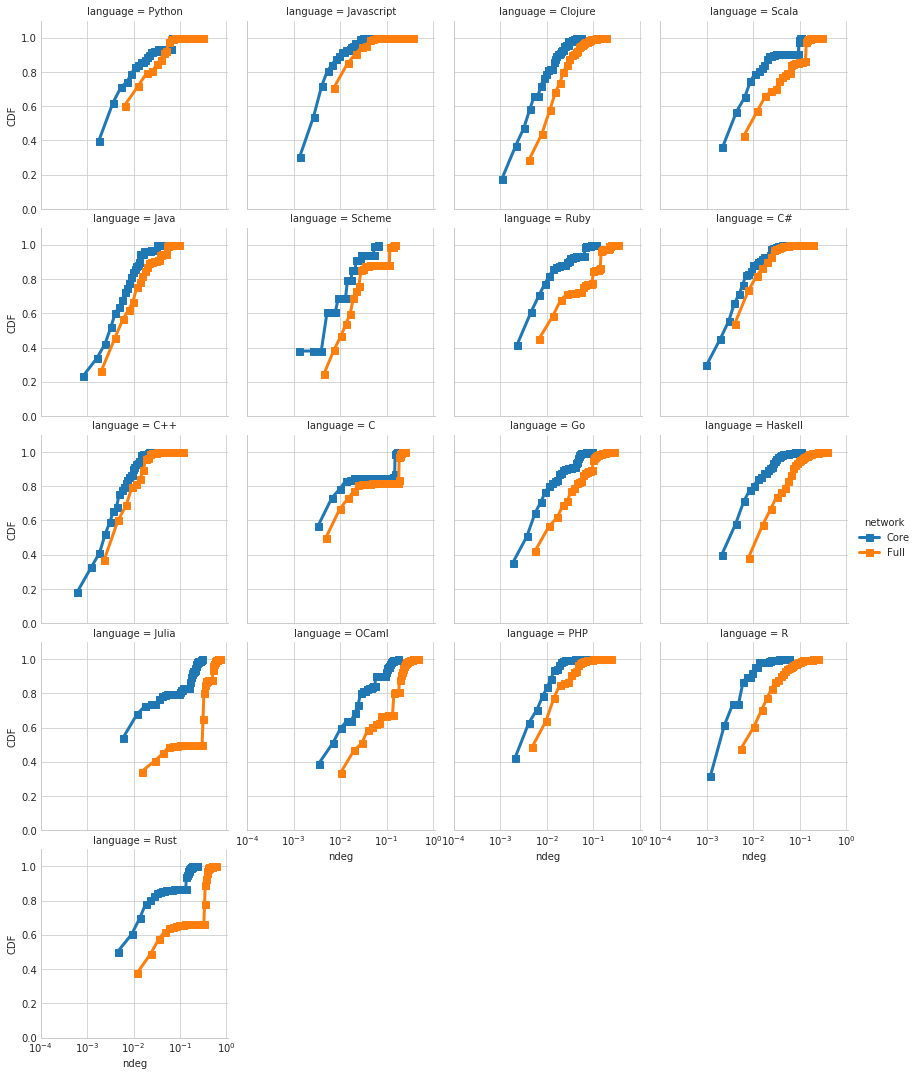

In [27]:
degDistPlot(tcCoreDF, tcFullDF)